# Predicting Wind Turbine Yield

Dataset is available here: https://www.kaggle.com/datasets/psycon/wind-turbine-energy-kw-generation-data

Research Questions:
- What are the environmental conditions under which the wind turbine operates?
- When and why does the wind turbine absorb power?
- How often is the turbine limited by the wind, and how often by the grid?
- What is the cut-in and cut-out wind speed for this wind turbine?

Workflow:
- checking differences in output power between years: looking for year-to-year differences
- looking for a seasonal trend
- identifying correlations
- data cleaning

Methods:
- we can explore time-series based, but also other methods

In [ ]:
# What I can calculate:
# - apparent power
# - line frequency vs. active power

# Research Questions:
# - how often is the wind turbine power limited?

# My Questions:
# - why is the active power negative? Is it because self consumption?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from math import ceil, floor
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from utils import remove_outliers_iqr

## Loading the data

In [2]:
feature_units = pd.read_csv("kaggle_dataset/feature_units.csv")
features = pd.read_csv("kaggle_dataset/features.csv", index_col="Timestamp")
features.index = pd.to_datetime(features.index)

power = pd.read_csv("kaggle_dataset/power.csv", index_col="Timestamp")
power.index = pd.to_datetime(power.index)

In [3]:
feature_units.shape, features.shape, power.shape

((77, 2), (154262, 76), (136730, 1))

In [4]:
features.index.min(), features.index.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2021-12-14 23:50:00'))

In [5]:
dataset_days = round(features.index.shape[0] / (6*24))
print(f"This dataset consists of {dataset_days} days")

This dataset consists of 1071 days


## Data Cleaning
Time series methods might have different handling of outliers, as we cannot simply drop them

In [6]:
nans_per_feature = features.isna().sum()
nans_per_feature.loc[nans_per_feature > 5000]

Gearbox_Oil_Temperature                              5176
Moment D Direction                                   5231
Temperature Heat Exchanger Converter Control Unit    5186
Pitch Offset-1 Asymmetric Load Controller            5023
Wind Deviation 10 seconds                            5132
Proxy Sensor_Degree-135                              5337
Pitch Demand Baseline_Degree                         5188
Blade-1 Set Value_Degree                             5506
Moment Q Filltered                                   5160
dtype: int64

In [7]:
# cols_to_drop = list(nans_per_feature[nans_per_feature > 5000].index)  # drop features which have more than 20% NaNs
# features.drop(columns=cols_to_drop, inplace=True)
# print("Dropping:", cols_to_drop)

# print("Before dropping rows with NaNs:", X.shape)
# X.dropna(inplace=True)
# y = y.loc[X.index]
# print("After dropping rows with NaNs:", X.shape)

### Checking dtypes
All features are numerical, some might be continuous, some might be discrete.

In [8]:
sum(features.dtypes != float)

0

### Looking for duplicates

In [9]:
features.duplicated().sum()

0

### Looking for outliers

In [10]:
features_per_unit = feature_units.groupby('Unit').count().T
features_per_unit.columns

Index(['( )', '(%)', '()', '(Hz)', '(Nm)', '(V)', '(bar)', '(kNm)', '(kVAr)',
       '(kW)', '(mm)', '(mm/s²)', '(ms)', '(rpm)', '(°)', '(°C)'],
      dtype='object', name='Unit')

Temperatures in wind turbines do not reach 99999°C, these are missing values. After cleaning the temperatures seem realistic.

In [11]:
feature_units.loc[feature_units['Unit'] == '(V)', 'Column'].to_list()

['Voltage A-N', 'Voltage C-N', 'Voltage B-N', 'Converter Control Unit Voltage']

In [12]:
temperature_features = feature_units.loc[feature_units['Unit'] == '(°C)', 'Column'].to_list()
angle_features = feature_units.loc[feature_units['Unit'] == '(°)', 'Column'].to_list()

In [13]:
# Replaing 99999 in all features with a NaN
for col in features.columns:
    features[col].loc[features[col] == 99999] = np.nan

Some parts of the turbine on average are hotter than others. No part can be colder than -50°C, so these values are removed

(-10.0, 150.0)

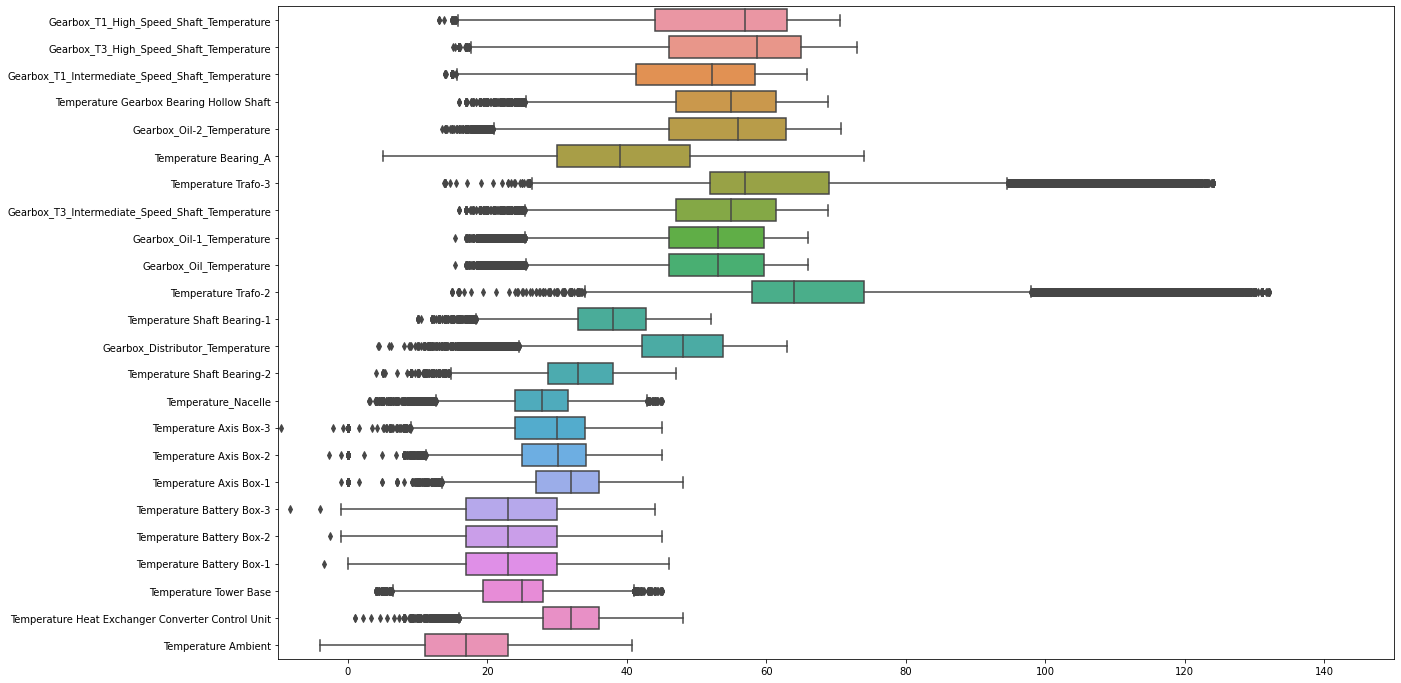

In [14]:
plt.figure(figsize=(20,12))
sns.boxplot(data=features[temperature_features], orient='h')
plt.xlim([-10, 150])

All angles should be in 0-360 degree range. How to deal with 391-1 switches?

In [15]:
n = floor(features[angle_features].min().min() / 360)

if n < 0:
    features[angle_features] += -n * 360
    features[angle_features] = features[angle_features] % 360
    
# (features[angle_features] % 360).describe()

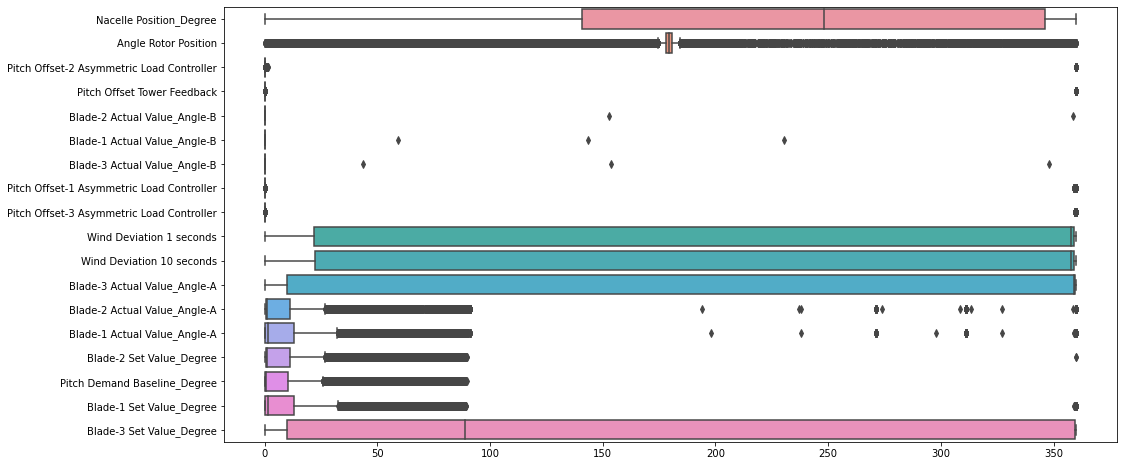

In [16]:
plt.figure(figsize=(16,8))
sns.boxplot(data=features[angle_features], orient='h')
plt.show()

### Removing outliers
When using time series models we cannot simply remove outliers, because they contain time information?

Can we simply replace extreme values with NaNs?

Warning: Dropping NaNs can actually remove important information!

In [17]:
# Remaining features
other = set(features.columns) - set(temperature_features + angle_features)

In [18]:
def find_outliers_iqr(X):
    for col in X.columns:
        feature = X[col]
        q1 = feature.quantile(0.25)
        q3 = feature.quantile(0.75)
        iqr = q3 - q1
        mask = feature.loc[((feature < (q1 - 1.5 * iqr)) | (feature > (q3 + 1.5 * iqr)))].index
        if len(mask) > 0:
            print(col, len(mask))

In [19]:
find_outliers_iqr(features[other])

C:\Users\danie\AppData\Local\Temp\ipykernel_15400\4260805748.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  find_outliers_iqr(features[other])


Scope CH 4 24241
Moment D Direction 2267
Tower Accelaration Normal Raw 17472
Torque 11998
State and Fault 27521
Tower Acceleration Normal 5865
Converter Control Unit Reactive Power 1127
Proxy Sensor_Degree-135 1306
Moment Q Direction 4877
Reactive Power 1276
Nacelle Revolution 21
Torque Offset Tower Feedback 8581
Hydraulic Prepressure 7135
Voltage C-N 266
Voltage A-N 177
Converter Control Unit Voltage 3509
Line Frequency 3841
Proxy Sensor_Degree-45 719
Proxy Sensor_Degree-225 785
Tower Accelaration Lateral Raw 22531
Turbine State 28199
External Power Limit 16
Internal Power Limit 2253
Voltage B-N 192
N-set 1 27784
Operating State 27362
Tower Acceleration Lateral 3770
Moment D Filtered 2247
Tower Deflection 12428
Moment Q Filltered 4848
Proxy Sensor_Degree-315 234


In [20]:
# print(features.isna().sum().sum())
# features = remove_outliers_iqr(features, other)
# print(features.isna().sum().sum())

In [65]:
# Why is there Torque of 300% ??
features['Torque'].describe()

count    148735.000000
mean         23.668063
std          91.267029
min        -327.679993
25%          10.118700
50%          39.902615
75%          86.597309
max         327.670013
Name: Torque, dtype: float64

## Exploratory Data Analysis

### Investigating correlations

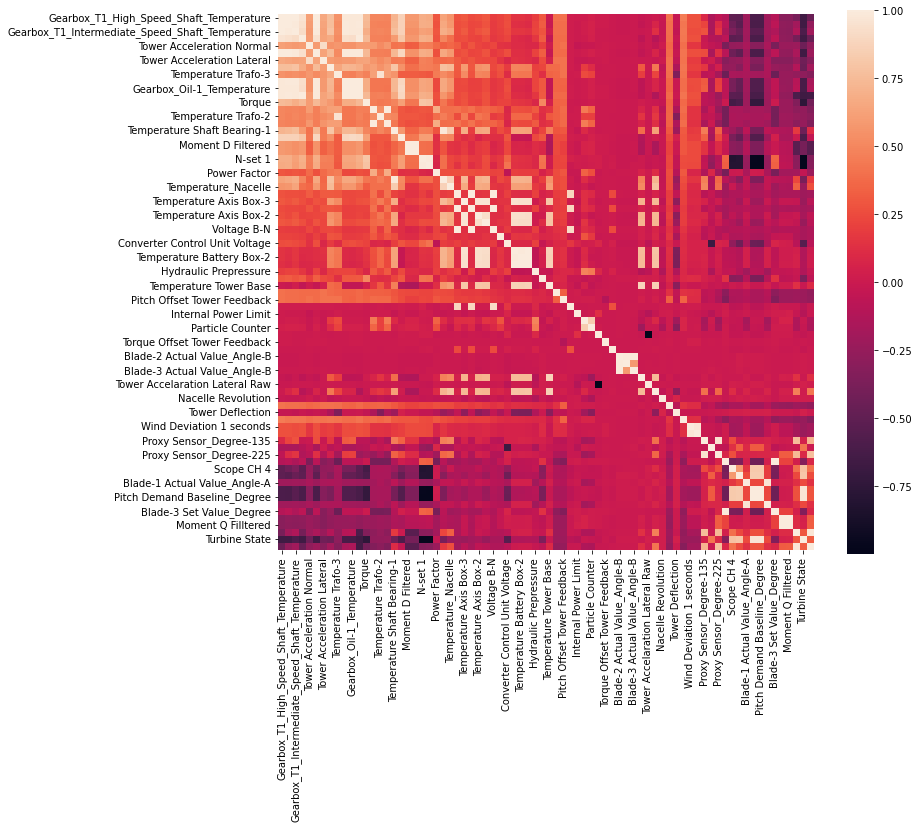

In [21]:
corr_matrix = features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, square=True)
plt.show()

### Investigating Ambient Conditions
Nacelle heats up ~ linearly with ambient temperature, can be hotter than the surrounding air but never is colder. This makes sense, as power electronics inside the nacelle release heat.

Nacelle temperature seems independent of active and reactive power generated by the turbine, as well as torque of the rotor. Correlation between nacelle temperature and generated power could indicated damage in power electronic components (excess heating).

(0.0, 50.0)

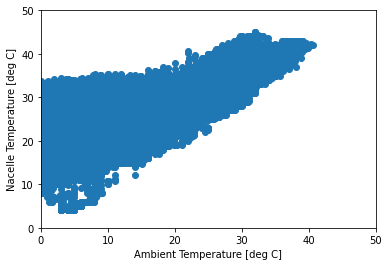

In [22]:
plt.scatter(x=features['Temperature Ambient'], y=features['Temperature_Nacelle'])
plt.xlabel("Ambient Temperature [deg C]")
plt.ylabel("Nacelle Temperature [deg C]")
plt.xlim([0, 50])
plt.ylim([0, 50])

(0.0, 50.0)

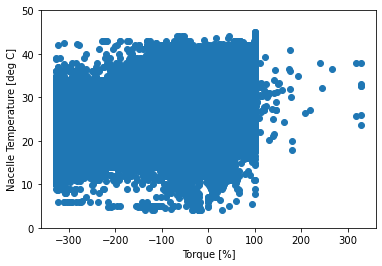

In [83]:
plt.scatter(x=features['Torque'], y=features['Temperature_Nacelle']) # .loc[power.index]
plt.xlabel("Torque [%]")
plt.ylabel("Nacelle Temperature [deg C]")
# plt.xlim([0, 50])
plt.ylim([0, 50])

### What influences active power generation?
Surprising: for large torque sometimes no power production

Generation is sometimes limited by internal limit, but almost never by the esternal limit (power grid). 

In [24]:
power.max()

Power(kW)    2779.42334
dtype: float64

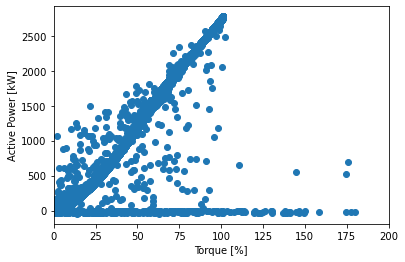

In [53]:
plt.scatter(x=features['Torque'].loc[power.index], y=power)
plt.xlabel("Torque [%]")
plt.ylabel("Active Power [kW]")
plt.xlim([0, 200])
plt.show()

(0.0, 3000.0)

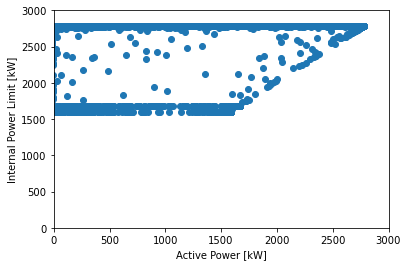

In [26]:
plt.scatter(x=power, y=features['Internal Power Limit'].loc[power.index])
plt.xlabel("Active Power [kW]")
plt.ylabel("Internal Power Limit [kW]")
plt.xlim([0, 3000])
plt.ylim([0, 3000])

In [27]:
# This many times power production is limited by the grid 
(features['External Power Limit'] < features['Internal Power Limit']).sum()

6

### Analysing Conditions When Grid Frequency is far from 50Hz
What is the max margin around 50Hz tolerated by the grid? How does a wind turbine behave when there is no power in the grid?

In [82]:
grid_off = features.loc[power.index].loc[(features['Line Frequency'] < 49.5) | (features['Line Frequency'] > 50.5)].copy()
len(grid_off)

84

### When and why is the active power negative?

When Torque is negative, active power is also negative

<AxesSubplot:ylabel='Count'>

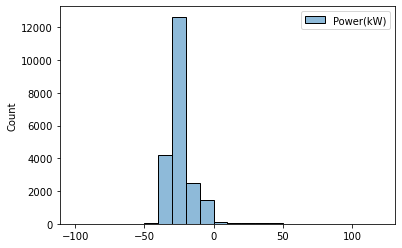

In [70]:
sns.histplot(power.loc[features['Torque'] < 0], binwidth=10, binrange=(-100, 120))

In [29]:
power.isna().sum()

Power(kW)    0
dtype: int64

Why so many values of power are negative? Is it possible for a wind turbine to consume electricity?

In [30]:
power['Power(kW)'].min()

-48.5966682434082

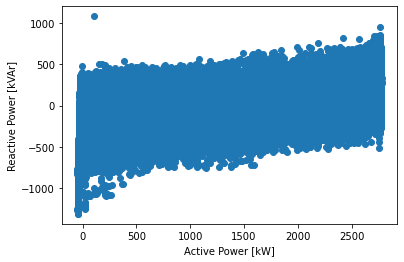

In [35]:
plt.scatter(x=power, y=features['Reactive Power'].loc[power.index])
plt.xlabel("Active Power [kW]")
plt.ylabel("Reactive Power [kVAr]")
plt.show()

Active power is almost always positive while reactive power changes sign.

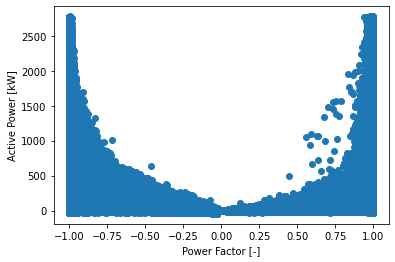

In [32]:
plt.scatter(x=features['Power Factor'].loc[power.index], y=power)
plt.xlabel("Power Factor [-]")
plt.ylabel("Active Power [kW]")
plt.show()

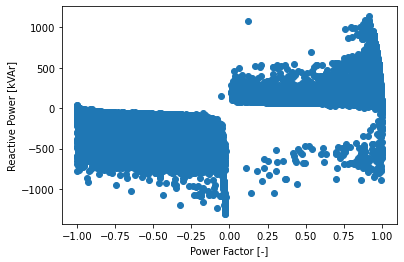

In [33]:
plt.scatter(x=features['Power Factor'], y=features['Reactive Power'])
plt.xlabel("Power Factor [-]")
plt.ylabel("Reactive Power [kVAr]")
plt.show()

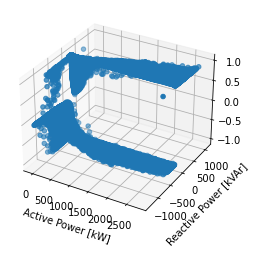

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Axes3D.scatter(xs=power, ys=features['Reactive Power'].loc[power.index], 
               zs=features['Power Factor'].loc[power.index], ax=ax)
plt.xlabel("Active Power [kW]")
plt.ylabel("Reactive Power [kVAr]")
# plt.zlabel("Power Factor [-]")
plt.show()

count    23705.000000
mean      -174.314340
std        224.428241
min      -1307.984985
25%       -311.864990
50%       -143.386673
75%          0.000000
max        474.959991
Name: Reactive Power, dtype: float64


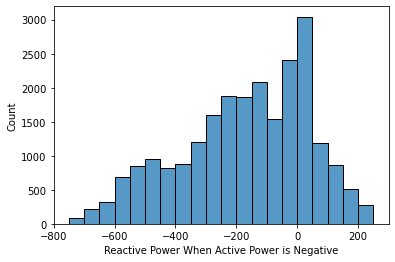

In [28]:
mask = power.loc[power['Power(kW)'] < 0].index
features_neg_power = features.loc[mask]
print(features_neg_power['Reactive Power'].describe())

sns.histplot(features_neg_power['Reactive Power'], binrange=(-750, 250), binwidth=50)
plt.xlabel("Reactive Power When Active Power is Negative")
plt.show()

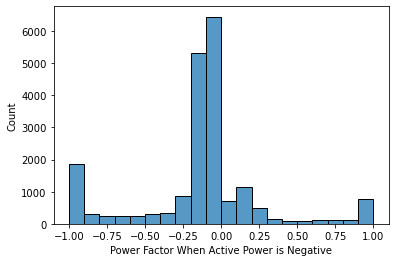

In [28]:
sns.histplot(features_neg_power['Power Factor'], binrange=(-1, 1), binwidth=0.1)
plt.xlabel("Power Factor When Active Power is Negative")
plt.show()

<AxesSubplot:xlabel='Torque', ylabel='Count'>

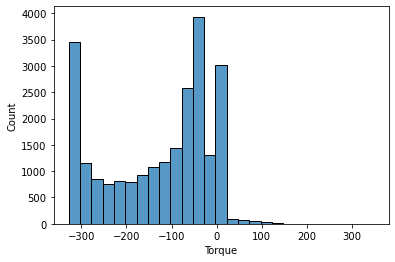

In [29]:
sns.histplot(features_neg_power['Torque'], binwidth=25)

### No Wind Conditions
During no wind conditions reactive power is usually zero and active power is negative. This was expected, as without wind there is no power generated while some power is consumed to keep the measuring equipment running, to heat up oil and blades, power the lights and maintain pitch control among others. More complete list of power loads in wind turbines can be found here: http://www.aweo.org/windconsumption.html

In [47]:
no_wind_features = features.loc[features['Torque'] == 0]

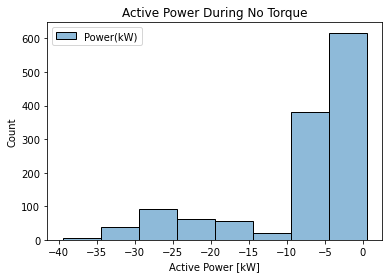

In [49]:
sns.histplot(power.loc[features['Torque'] == 0], binwidth=5)
plt.title("Active Power During No Torque")
plt.xlabel("Active Power [kW]")
plt.show()

<AxesSubplot:xlabel='Reactive Power', ylabel='Count'>

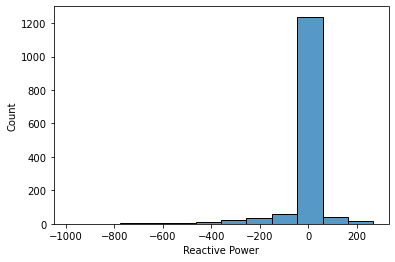

In [50]:
sns.histplot(no_wind_features['Reactive Power'])

### Control System

In [86]:
# We can calculate discrepancy between the set and actual angle of the blade. This way we can investigate if
# delay or noise in the control signal can influence power factor or active power

# SOLVE THE 359-1 DEGREE ISSUE!
(features['Blade-1 Set Value_Degree'] - features['Blade-1 Actual Value_Angle-A']).describe()

count    141498.000000
mean         -0.744932
std          19.091107
min        -359.999823
25%          -0.003159
50%           0.000014
75%           0.003128
max         359.999355
dtype: float64

### Voltage and Reactive Power
Wind turbines are often in remote locations and therefore, they need to maintain line volatage by producing reactive power. Therefore, line-to-neutral voltage and reactive power are correlated. Note that voltage signals are not sinusoidal because of the 10 min sampling frequency.

In [196]:
features[['Voltage A-N', 'Voltage B-N', 'Voltage C-N']].describe()

,Voltage A-N,Voltage B-N,Voltage C-N
count,148288.000000,149093.000000,148965.000000
mean,400.137964,396.773473,397.090545
std,10.177121,9.717684,9.637928
min,0.000000,0.000000,0.000000
25%,397.079987,394.241669,394.236664
50%,400.583344,397.656677,397.723328
75%,403.994995,399.921661,400.556671
max,415.266663,410.956665,412.161652


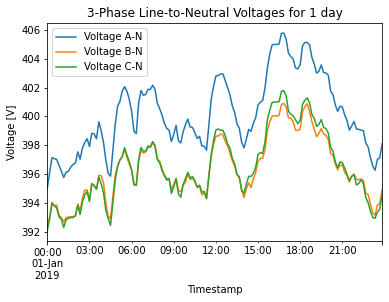

In [30]:
features[['Voltage A-N', 'Voltage B-N', 'Voltage C-N']].iloc[0:6*24].plot()
plt.title("3-Phase Line-to-Neutral Voltages for 1 day")
plt.ylabel("Voltage [V]")
plt.show()

(380.0, 420.0)

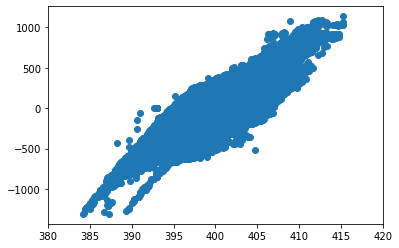

In [228]:
plt.scatter(features['Voltage A-N'], features['Reactive Power'])
plt.xlim([380, 420])

Summary of the findings:
- generation is limited by the internal, not the external limit, which means wind turbine switches off due to too high wind speed, rather than grid nto being able to absorb the energy. Grid frequency is very stable and stays within +-0.5 Hz almost at all times.
- reactive power and voltage are correlated, as reactive power is used to maintain line voltage
- ambient temperatures stay between 0 and 40 degrees Celsius with mean around 20 C
- active power is often negative <-- WHY?
- active and reactive power are (weakly) correlated

TODOs:
- fix 359-1 angle issue
- calculate error in provided signal (pitch control)
- understand when wind turbine generates reactive power --> Is it regulated by the power system operator?
- why torque [%] has so many values outside 0-100 range??

## Time Series Decomposition
Wind speed / power time series is expected to have seasonality, as wind speeds tend to be higher in winter. 

Statistical properties of time series such as mean, variance should remain constant over time to call time series is stationary:
- constant mean
- constant variance
- autocovariance that does not depend on time. autocovariance is covariance between time series and lagged time series.

https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda

In [31]:
# # Test for stationarity
# y = power['Power(kW)']
# adf_test = adfuller(y, regression='c')
# print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
#       .format(adf_test[0], adf_test[1], adf_test[2]))
# for key, value in adf_test[4].items():
#     print('Critical Value ({}): {:.6f}'.format(key, value))

In [103]:
power.resample("Y")['Power(kW)'].sum()

Timestamp
2019-12-31    5.852937e+07
2020-12-31    6.182047e+07
2021-12-31    3.532497e+07
Freq: A-DEC, Name: Power(kW), dtype: float64

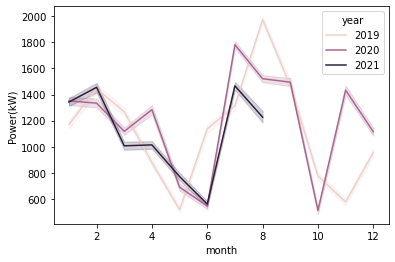

In [198]:
power['month'] = power.index.month
power['year'] = power.index.year

sns.lineplot(data=power, x='month', y='Power(kW)', hue='year', legend='full')
plt.show()

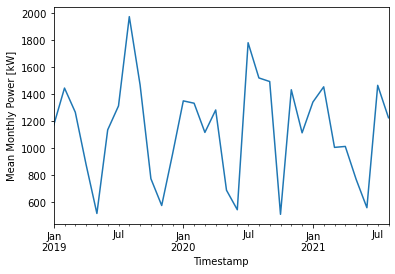

In [130]:
power_monthly = power['Power(kW)'].resample('M').mean()

power_monthly.plot()
plt.ylabel("Mean Monthly Power [kW]")
plt.show()

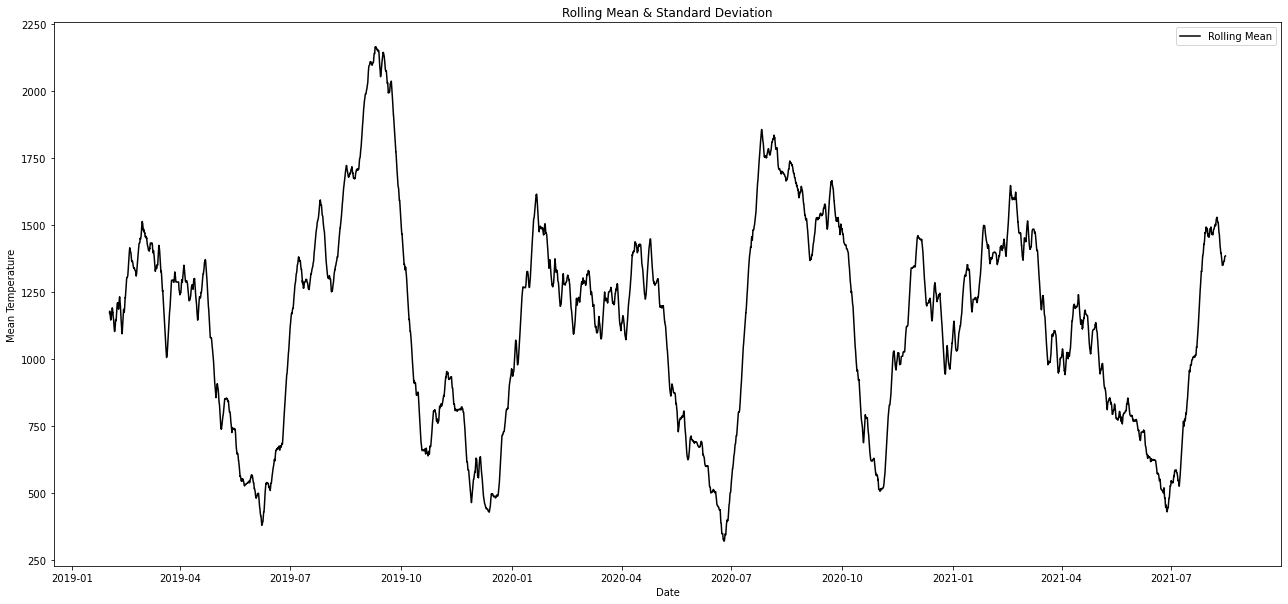

In [112]:
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(window=6*24*31).mean()
    rolstd = ts.rolling(window=6*24*31).std()
    plt.figure(figsize=(22,10))   
#     orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
#     std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
# check_mean_std(power.loc[power['year'] == 2019, 'Power(kW)'])
check_mean_std(power['Power(kW)'])

Mean (black) is not constant, variance (green) is also not constant --> not stationary?

In ADF the test statistic is below the critical value -> stationary?

Time series is definitely not stationary (based on constant mean and variance requirement).

In [ ]:
check_adfuller(power.loc[power['year'] == 2019, 'Power(kW)'])

In [ ]:
check_adfuller(power['Power(kW)'])

- As we mentioned before, there are 2 reasons behind non-stationarity of time series
    - Trend: varying mean over time. We need constant mean for stationary of time series.
    - Seasonality: variations at specific time. We need constant variations for stationary of time series.
- First solve trend(constant mean) problem
    - Most popular method is moving average.
        - Moving average: We have window that take the average over the past 'n' sample. 'n' is window size.
        
There should be no trend, as the power output is not increasing or decreasing over time. Perhaps if we had data over a full lifetime of a turbine we could see decay of its performance over time. 

There should be seasonality, as wind speeds change with seasons, they often are higher in winter. PV and wind can sometimes be complementary.

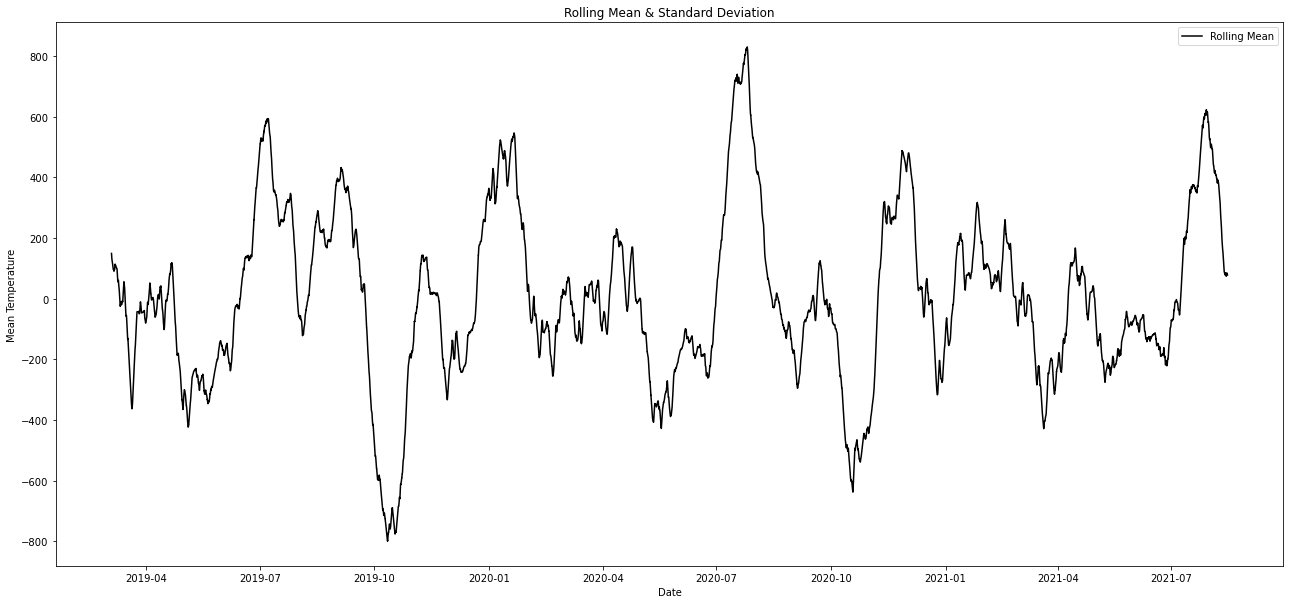

In [128]:
ts_moving_avg_diff = power['Power(kW)'] - moving_avg
ts_moving_avg_diff.dropna(inplace=True) # first 6 is nan value due to window size

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
# check_adfuller(ts_moving_avg_diff.MeanTemp)

- Seasonality: describes the periodic signal in your time series.
- Trend: describes whether the time series is decreasing, constant, or increasing over time.
- Noise: describes what remains behind the separation of seasonality and trend from the time series. In other words, it’s the variability in the data that cannot be explained by the model.

https://towardsdatascience.com/time-series-decomposition-in-python-8acac385a5b2

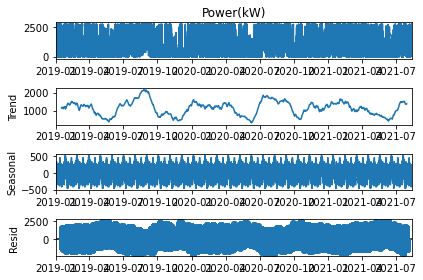

In [200]:
result = seasonal_decompose(power['Power(kW)'], model='additive', period=31*24*6)  # power_monthly
result.plot()
plt.show()

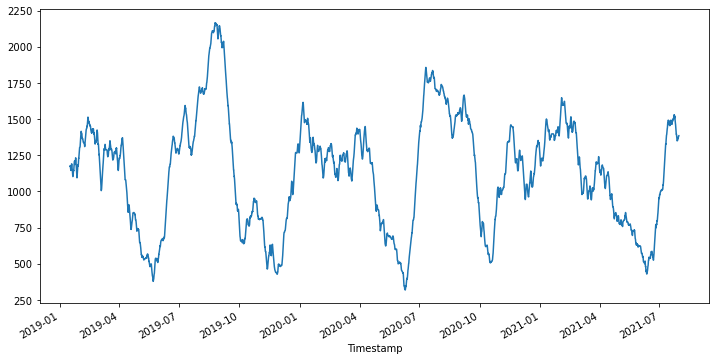

In [206]:
plt.figure(figsize=(12, 6))
result.trend.plot()
plt.show()

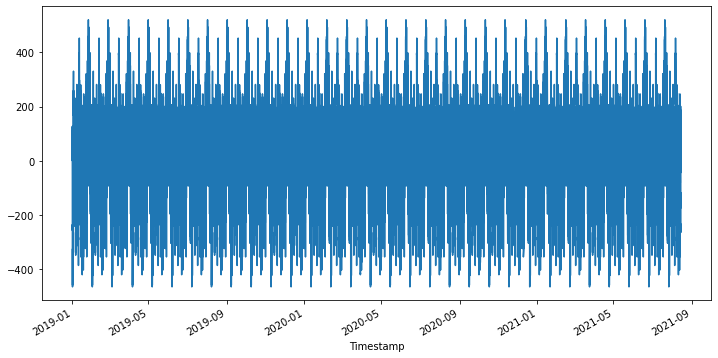

In [154]:
plt.figure(figsize=(12, 6))
result.seasonal.plot()
plt.show()

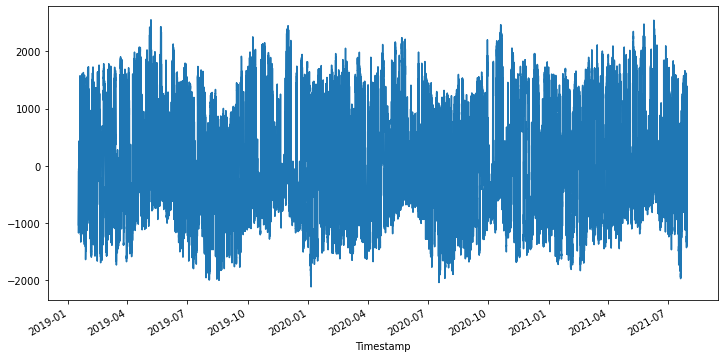

In [153]:
plt.figure(figsize=(12, 6))
result.resid.plot()
plt.show()

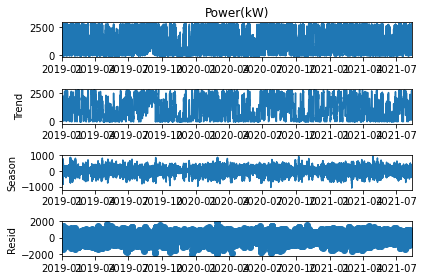

In [216]:
stl = STL(power['Power(kW)'], period=7*6)
res = stl.fit()
res.plot()
plt.show()

<AxesSubplot:xlabel='Timestamp'>

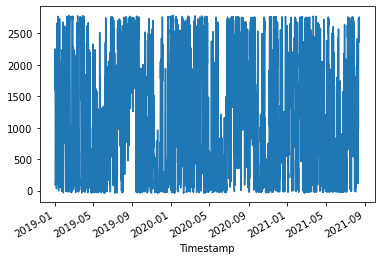

In [217]:
res.trend.plot()

<AxesSubplot:xlabel='Timestamp'>

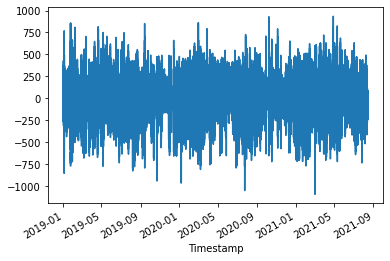

In [218]:
res.seasonal.plot()

## Feature Engineering

In [ ]:
# Month
# Year

## Modeling
Exploring timeseries methods, as well as regression methods with lagged features.